# Transfer Learning and Fine-tuning Image Classifier for UI Data Classification

Image classification models consist of millions of parameters. Training them from scratch requires a large amount of labeled training data and substantial computing power. Transfer learning is a technique that reduces this resource consumption by reusing parts of a model already trained on a related task in a new model.

This Colab notebook aims to create a model for classifying UI data. It performs image feature extraction using a pre-trained TF2 SavedModel from TensorFlow Hub (trained on a larger and more general ImageNet dataset), and builds a Keras model to classify the UI data based on this. Additionally, it includes the process of fine-tuning the feature extractor with the newly added classifier.

Finally, this model is converted for TFJS, making it easily usable on the web.

This notebook was created by reworking [Google's official tutorial document](https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=ko).

## 1. Setup
### 1-1. Importing Libraries

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.14.0
Hub version: 0.16.0.dev
GPU is available


### 1-2. Selecting a TF2 SavedModel Module

In this notebook, we use the [https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5](https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5) model by default. This URL can be used in the code to identify the SavedModel and display its documentation in the browser.

You can choose from various models. You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

> **Note**: Although TensorFlow Hub has moved to [Kaggle Models](https://www.kaggle.com/models), you can still use the models in the same way as before.

In [2]:
#@title

model_name = "mobilenet_v3_large_075_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v3_large_075_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5
Input size (224, 224)


## 2. Preparing the UI Dataset

The input is adjusted to the appropriate size according to the selected module. Dataset augmentation (i.e., random distortion of the image each time it is read) can particularly improve training when fine-tuning. To preparing the dataset, you need to aware the following:

1. Collect images of UI components from actual projects or screen captures. It is advisable to secure at least 50 images for each UI component, and the recommended quantity is more than 100 images.
2. If it is difficult to secure such a quantity of images, it is recommended to generate images using [figma-dummy-gen](https://github.com/dusskapark/figma-dummy-gen) and use them in conjunction with the images actually captured.
3. Put the prepared dataset in the `dataset` folder.

In [3]:
# Define the root path and the origin path
root_path = os.path.expanduser('./dataset/')
origin_path = root_path + 'TF_Image_classification/' # folder that contains the dummy images
screenshot_path = root_path + 'screenshot/' # folder that contains the real images that captured from the UI or Figma projects 
ui_path = root_path + 'ui/' # final UI dataset folder 

# Print the root path and the origin path
print('Origin path:', origin_path)
print('Screenshot path:', screenshot_path)
print('UI path:', ui_path)


Origin path: ./dataset/TF_Image_classification/
Screenshot path: ./dataset/screenshot/
UI path: ./dataset/ui/


### 2-1. Checking the Original Dataset Structure

The dataset is stored in the `origin_path`. The folder structure is as follows:

```
TF_Image_classification
|__ Accordion
    |______ 100080576_f52e8ee070_n.jpg
    |______ 14167534527_781ceb1b7a_n.jpg
    |______ ...
|__ App Bar
    |______ 10043234166_e6dd915111_n.jpg
    |______ 1426682852_e62169221f_m.jpg
    |______ ...
```

You can use the following code to identify the names of each folder and the number of files in each folder.

In [4]:
# Function to get the number of files in a directory
def get_num_files(path):
    return len([entry for entry in os.scandir(path) if entry.is_file()])

# Function to print the directory tree
def draw_folder_tree(path, level=0):
    expanded_path = os.path.expanduser(path)
    folders_files_count = {}

    for entry in os.scandir(expanded_path):
        if entry.is_dir():
            num_files = get_num_files(entry.path)
            folders_files_count[entry.name] = num_files

    sorted_folders_files_count = sorted(folders_files_count.items(), key=lambda item: item[0])

    for folder_name, files_count in sorted_folders_files_count:
        print(f"{'    '*level}|- {folder_name}/ ({files_count} files)")
        draw_folder_tree(os.path.join(path, folder_name), level+1)
        
# Draw the folder tree of the new directory
print('Train structure:')
draw_folder_tree(origin_path)

Train structure:
|- Bottom app bars/ (32 files)
|- Bottom sheets/ (16 files)
|- Buttons/ (200 files)
|- Cards/ (25 files)
|- Carousel/ (57 files)
|- Checkboxes/ (120 files)
|- Chips/ (960 files)
|- Date picker/ (33 files)
|- Dialogs/ (28 files)
|- FABs/ (256 files)
|- Icon buttons/ (240 files)
|- Menu/ (37 files)
|- Menu List/ (2305 files)
|- Navigation bars/ (25 files)
|- Navigation drawer/ (129 files)
|- Navigation rails/ (25 files)
|- Progress indicators/ (40 files)
|- Radio buttons/ (40 files)
|- Search/ (128 files)
|- Segmented buttons/ (65 files)
|- Side sheets/ (32 files)
|- Sliders/ (201 files)
|- Switch/ (80 files)
|- Tabs/ (41 files)
|- Text Fields/ (960 files)
|- Time picker/ (25 files)
|- Tooltips/ (8 files)
|- Top app bars/ (256 files)



### 2-2. Adjusting Dataset Images

The images in the dataset must be adjusted to match the input size of the model. For example, for MobileNetV3, the input size is 224x224x3, so the images in the dataset need to be adjusted to this size. The adjusted images are stored in the `ui_path` folder.


In [5]:
from PIL import Image

# Set the limit for the number of images per folder
LIMIT_IMAGES = 200  # Set to None for no limit

# Create the new directory if it doesn't exist
os.makedirs(ui_path, exist_ok=True)

# Get the list of all folders in the origin and screenshot paths
all_folders = set(os.listdir(origin_path) + os.listdir(screenshot_path))

# Loop through each folder in the list
for folder_name in all_folders:
    # Construct the full path to the origin and screenshot folders
    origin_folder_path = os.path.join(origin_path, folder_name)
    screenshot_folder_path = os.path.join(screenshot_path, folder_name)

    # Check if the origin and screenshot folders exist
    origin_exists = os.path.isdir(origin_folder_path)
    screenshot_exists = os.path.isdir(screenshot_folder_path)

    # If neither folder exists, skip this folder
    if not origin_exists and not screenshot_exists:
        print(f"Folder {folder_name} does not exist in either the origin or screenshot path. Please check the data.")
        continue

    # Get the list of files in the origin and screenshot folders
    origin_files = os.listdir(origin_folder_path) if origin_exists else []
    screenshot_files = os.listdir(screenshot_folder_path) if screenshot_exists else []

    # If there is a limit and the number of screenshot files is greater than the limit
    if LIMIT_IMAGES is not None and len(screenshot_files) > LIMIT_IMAGES:
        print(f"Folder {folder_name} has more than {LIMIT_IMAGES} images. Please check the data.")
        continue

    # Calculate the number of files to select from the origin folder
    num_files_to_select = min(len(origin_files), LIMIT_IMAGES-len(screenshot_files)) if LIMIT_IMAGES is not None else len(origin_files)

    # Randomly select files from the origin folder
    selected_origin_files = np.random.choice(origin_files, size=num_files_to_select, replace=False).tolist() if num_files_to_select > 0 else []

    # Combine the screenshot and selected origin files
    combined_files = screenshot_files + selected_origin_files

    # Shuffle the combined files
    np.random.shuffle(combined_files)

    # Create the new folder if it doesn't exist
    new_folder_path = os.path.join(ui_path, folder_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Loop through each file in the combined files
    for filename in combined_files:
        # Only process .png files
        if filename.endswith('.png'):
            # Check if the file is from the screenshot or origin folder
            if filename in screenshot_files:
                folder_path = screenshot_folder_path
            else:
                folder_path = origin_folder_path

            # Construct the full path to the file
            file_path = os.path.join(folder_path, filename)
            
            # Open the image file
            img = Image.open(file_path).convert("RGBA")
            
            # Get the width and height of the image
            width, height = img.size
            
            # Create a new square image with alpha channel
            new_image = Image.new('RGBA', (max(width, height), max(width, height)))
            
            # Paste the original image into the center of the new image
            new_image.paste(img, (int((new_image.width - img.width) / 2), int((new_image.height - img.height) / 2)))
            
            # Create a white background image
            bg = Image.new('RGBA', new_image.size, (255, 255, 255, 255))  # RGBA mode
            
            # Combine the new image with the white background
            final_image = Image.alpha_composite(bg, new_image)
            
            # Resize the final image to the target size
            final_image = final_image.resize([224, 224], Image.LANCZOS)
            
            # Construct the new file path
            new_file_path = os.path.join(new_folder_path, filename)
            
            # Save the new image as PNG
            final_image.save(new_file_path, format='PNG')
            
            # Print the result
            print(f"Saved new image at {new_file_path}")

Saved new image at ./dataset/ui/Progress indicators/Linear progress indicator - 2 - 02.png
Saved new image at ./dataset/ui/Progress indicators/Linear progress indicator-dark - 4 - 29.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator - 1 - 16.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator-dark - 1 - 36.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator-dark - 1 - 31.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator-dark - 3 - 38.png
Saved new image at ./dataset/ui/Progress indicators/Linear progress indicator-dark - 5 - 30.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator - 2 - 17.png
Saved new image at ./dataset/ui/Progress indicators/Linear progress indicator - 5 - 05.png
Saved new image at ./dataset/ui/Progress indicators/Circular progress indicator-dark - 2 - 32.png
Saved new image at ./dataset/ui/Progress indicat

In [6]:
# Draw the folder tree of the ui_path directory
print('UI structure:')
draw_folder_tree(ui_path)

UI structure:
|- Bottom app bars/ (32 files)
|- Bottom sheets/ (16 files)
|- Cards/ (192 files)
|- Checkboxes/ (182 files)
|- Chips/ (200 files)
|- Date picker/ (32 files)
|- FABs/ (200 files)
|- Menu/ (36 files)
|- Menu List/ (199 files)
|- Navigation bars/ (44 files)
|- Navigation rails/ (24 files)
|- Progress indicators/ (40 files)
|- Search/ (128 files)
|- Segmented buttons/ (64 files)
|- Side sheets/ (32 files)
|- Sliders/ (199 files)
|- Tabs/ (69 files)
|- Time picker/ (24 files)
|- Tooltips/ (8 files)


### 2-3. Converting to TensorFlow Dataset

Finally, use the `image_dataset_from_directory` function in TensorFlow to convert the `ui_path` folder into a TensorFlow dataset. This converted dataset is used for model training.

In [7]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      ui_path,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 1721 files belonging to 19 classes.
Using 1377 files for training.
Found 1721 files belonging to 19 classes.
Using 344 files for validation.


## 3. Training 

### 3-1. Defining the model

All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [8]:
do_fine_tuning = False #@param {type:"boolean"}

In [9]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2731616   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 19)                24339     
                                                                 
Total params: 2755955 (10.51 MB)
Trainable params: 24339 (95.07 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


### 3-2. Training the model

In [10]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10
86/86 [==============================] - 7s 56ms/step - loss: 1.3925 - accuracy: 0.7289 - val_loss: 0.9799 - val_accuracy: 0.8929
Epoch 2/10
86/86 [==============================] - 5s 44ms/step - loss: 0.8572 - accuracy: 0.9236 - val_loss: 0.8503 - val_accuracy: 0.9167
Epoch 3/10
86/86 [==============================] - 4s 47ms/step - loss: 0.7859 - accuracy: 0.9603 - val_loss: 0.7936 - val_accuracy: 0.9435
Epoch 4/10
86/86 [==============================] - 4s 44ms/step - loss: 0.7469 - accuracy: 0.9758 - val_loss: 0.7728 - val_accuracy: 0.9554
Epoch 5/10
86/86 [==============================] - 4s 43ms/step - loss: 0.7291 - accuracy: 0.9853 - val_loss: 0.7445 - val_accuracy: 0.9702
Epoch 6/10
86/86 [==============================] - 4s 45ms/step - loss: 0.7102 - accuracy: 0.9868 - val_loss: 0.7316 - val_accuracy: 0.9792
Epoch 7/10
86/86 [==============================] - 4s 44ms/step - loss: 0.7005 - accuracy: 0.9875 - val_loss: 0.7228 - val_accuracy: 0.9792
Epoch 8/10
86

### 3-3. Monitoring training progress

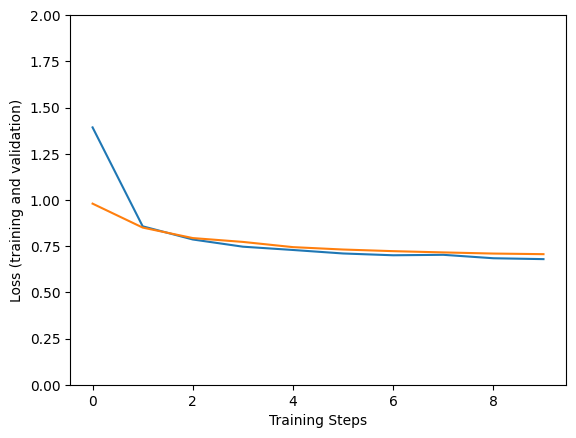

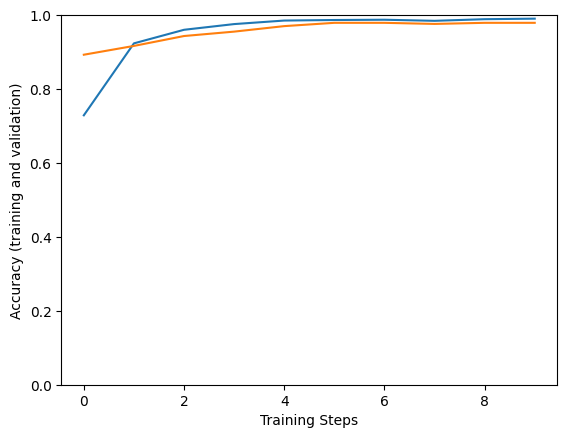

In [12]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

### 3-4. Testing the custom trained model

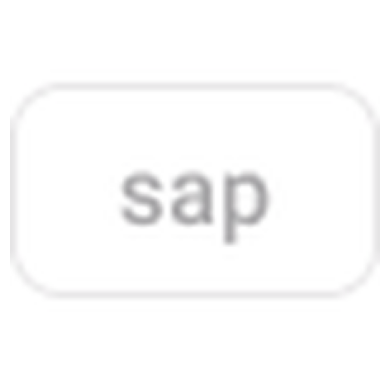

1/1 [==============================] - 1s 1s/step
True label: Chips
Predicted label: Chips


In [13]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

## 4. Save and convert the model

Finally, you can save the trained model to deploy it to TF Serving or TFJS as follows.

### 4-1. Saving the model

In [14]:
saved_model_path = f"{root_path}saved_model/{model_name}"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: ./dataset/saved_model/mobilenet_v3_large_075_224/assets


INFO:tensorflow:Assets written to: ./dataset/saved_model/mobilenet_v3_large_075_224/assets


### 4-2 Convert Saved_model to TFJS

Now that we have a trained model, we can convert it to TFJS format for use in the browser. We will use the `tensorflowjs_converter` to do this.

In [15]:
# set the path to the tfjs model
tfjs_model_path = f"{root_path}tfjs_model/{model_name}"

# convert the tf_saved_model to tfjs model via tensorflowjs_converter

!tensorflowjs_converter --input_format=tf_saved_model {saved_model_path} {tfjs_model_path} --output_format=tfjs_graph_model

In [16]:
import os
import json

# Set the base URL
base_url = "https://m3.material.io/components"

# List all folders in ui_path
folder_names = [entry.name for entry in os.scandir(ui_path) if entry.is_dir()]

# Function to convert name to URL
def name_to_url(name):
    # Convert to lower case and replace spaces with hyphens
    url_name = name.lower().replace(" ", "-")
    # Construct the URL
    url = f"{base_url}/{url_name}"
    return url

# Generate labels list
labels = [{"name": name, "url": name_to_url(name), "id": i+1} for i, name in enumerate(sorted(folder_names))]

print(labels)

# Write to metadata.json under the tfjs_model_path
with open(os.path.join(tfjs_model_path, "metadata.json"), "w") as f:
    json.dump({"labels": labels}, f)

[{'name': 'Bottom app bars', 'url': 'https://m3.material.io/components/bottom-app-bars', 'id': 1}, {'name': 'Bottom sheets', 'url': 'https://m3.material.io/components/bottom-sheets', 'id': 2}, {'name': 'Cards', 'url': 'https://m3.material.io/components/cards', 'id': 3}, {'name': 'Checkboxes', 'url': 'https://m3.material.io/components/checkboxes', 'id': 4}, {'name': 'Chips', 'url': 'https://m3.material.io/components/chips', 'id': 5}, {'name': 'Date picker', 'url': 'https://m3.material.io/components/date-picker', 'id': 6}, {'name': 'FABs', 'url': 'https://m3.material.io/components/fabs', 'id': 7}, {'name': 'Menu', 'url': 'https://m3.material.io/components/menu', 'id': 8}, {'name': 'Menu List', 'url': 'https://m3.material.io/components/menu-list', 'id': 9}, {'name': 'Navigation bars', 'url': 'https://m3.material.io/components/navigation-bars', 'id': 10}, {'name': 'Navigation rails', 'url': 'https://m3.material.io/components/navigation-rails', 'id': 11}, {'name': 'Progress indicators', 'ur